In [37]:
import numpy as np
import tensorflow as tf
import pandas as pd
import json
import matplotlib.pyplot as plt
import os
import cv2 as cv
from tqdm import tqdm
import string
import pytesseract
from PIL import Image


In [38]:
PATH = '../dataset/Date-Real/images/'

In [39]:
ANNOTATIONS_PATH = '../dataset/Date-Real//annotations.json'

with open(ANNOTATIONS_PATH, 'r') as file:
    data = json.load(file)

def get_y_from_json(file: str) -> str:
    return " ".join(annotation['transcription'] for annotation in data[file]['ann'])

Loading images: 100%|██████████| 510/510 [00:00<00:00, 1089.81it/s]


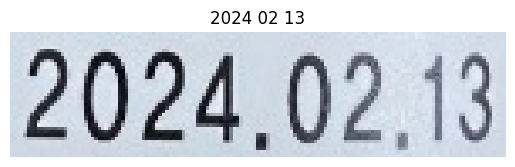

In [40]:
# Load dataset

X = []
Y = []


for idx, file in enumerate(tqdm(os.listdir(PATH), desc="Loading images")):

    file_path = os.path.join(PATH, file)

    image = Image.open(file_path)

    label = get_y_from_json(file)

    if label != " ":
        X.append(image)
        Y.append(label)

    
plt.imshow(X[100], cmap='gray')
plt.title(Y[100])
plt.axis('off')
plt.show()

In [41]:
def preprocess_image(image):
    image_cv = cv.cvtColor(np.array(image), cv.COLOR_RGB2BGR)

    image_cv = cv.resize(image_cv, (0, 0), fx=2, fy=2)  

    denoised = cv.fastNlMeansDenoisingColored(image_cv, None, 10, 10, 7, 21)

    gray = cv.cvtColor(denoised, cv.COLOR_BGR2GRAY)

    _, binary = cv.threshold(gray, 127, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    return binary

In [42]:
import re
from tqdm import tqdm
from PIL import Image
import pytesseract
import matplotlib.pyplot as plt

# Perform OCR and calculate accuracy
correct_predictions = 0
total_images = len(X)

ocr_results = []

def clean_text(text):
    return re.sub(r'[^0-9]', ' ', text).strip()

for idx in tqdm(range(total_images), desc="Performing OCR"):
    
    preprocessed_image = preprocess_image(X[idx])

    extracted_text = pytesseract.image_to_string(preprocessed_image, config='--psm 6')

    output = clean_text(extracted_text)

    ocr_results.append(output)

    if output == clean_text(Y[idx]):
        correct_predictions += 1

# Calculate accuracy
accuracy = (correct_predictions / total_images) * 100

print(f"Total Images: {total_images}")
print(f"Correct Predictions: {correct_predictions}")
print(f"Accuracy: {accuracy:.2f}%")



Performing OCR: 100%|██████████| 510/510 [02:38<00:00,  3.23it/s]

Total Images: 510
Correct Predictions: 257
Accuracy: 50.39%


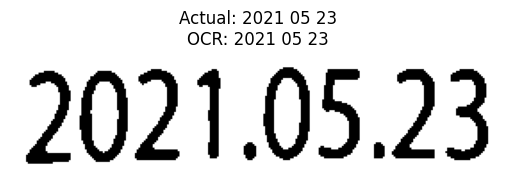

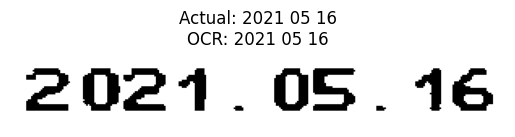

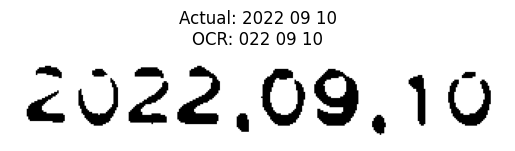

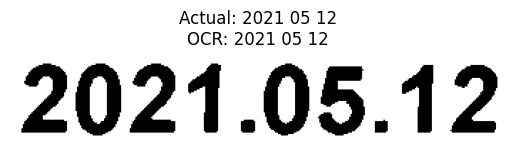

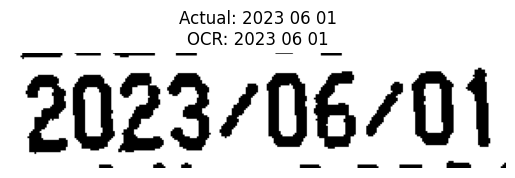

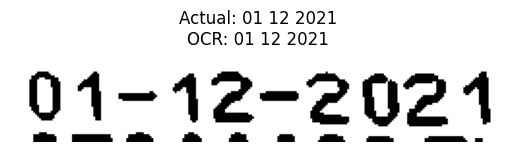

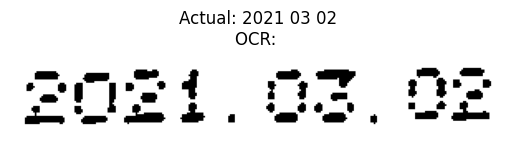

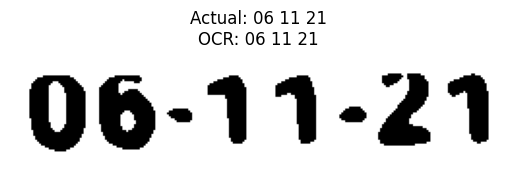

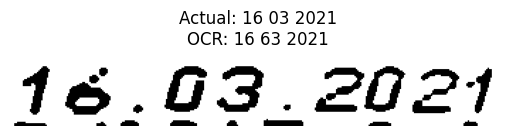

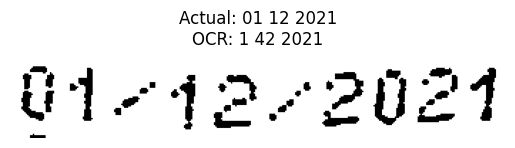

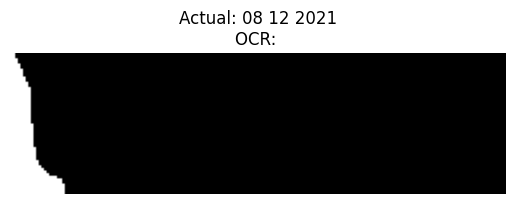

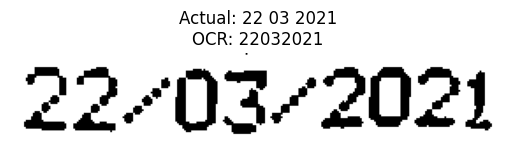

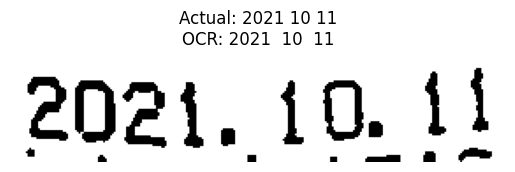

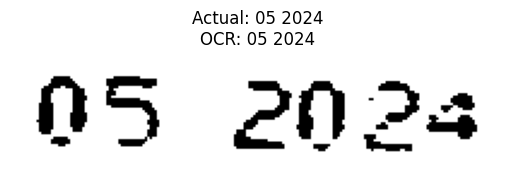

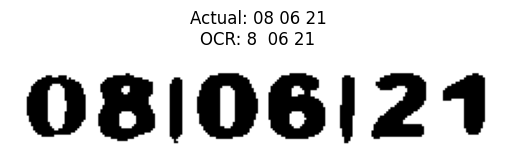

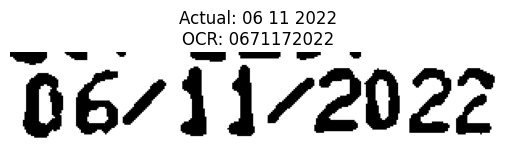

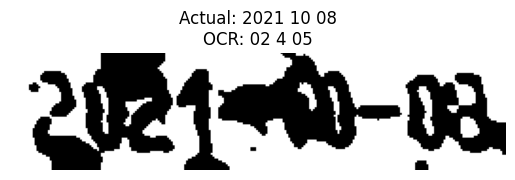

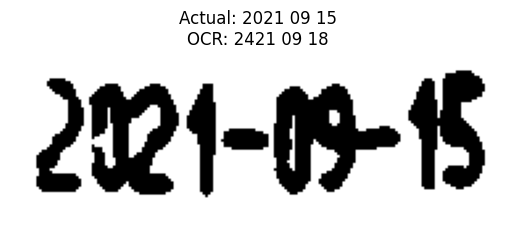

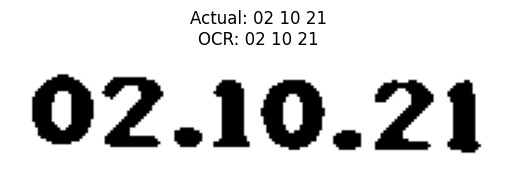

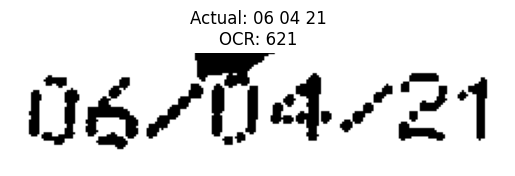

In [43]:
for i in range(20): 
    plt.imshow(preprocess_image(X[i]), cmap='gray')
    plt.title(f"Actual: {Y[i]}\nOCR: {ocr_results[i]}")
    plt.axis('off')
    plt.show()


In [44]:
X[0].shape

AttributeError: 'JpegImageFile' object has no attribute 'shape'